<a href="https://colab.research.google.com/github/ucancallmetigger-ui/Melanoma-Detector-CNN/blob/main/Melanoma_Detector_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from google.colab import files
from glob import glob
from sklearn.model_selection import train_test_split

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = 'your_username_from_kaggle_json'
os.environ['KAGGLE_KEY'] = 'your_key_from_kaggle_json'

!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

!unzip -q skin-cancer-malignant-vs-benign.zip -d skin_data

print("Dataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign
License(s): unknown
 97% 314M/325M [00:05<00:00, 43.3MB/s]
100% 325M/325M [00:05<00:00, 60.3MB/s]
Dataset downloaded and extracted!


In [3]:
data_dir = 'skin_data'

df_list = []

for split in ['train', 'test']:
    for label in ['benign', 'malignant']:
        folder = os.path.join(data_dir, split, label)
        if os.path.exists(folder):
            print(f"Found folder: {folder} with {len(os.listdir(folder))} images")
            for img in os.listdir(folder):
                if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder, img)
                    df_list.append({'path': img_path, 'label': label})

metadata = pd.DataFrame(df_list)

if len(metadata) == 0:
    print("No images found! Check download.")
else:
    print("Total images:", len(metadata))
    print(metadata['label'].value_counts())
    metadata.head()

Found folder: skin_data/train/benign with 1440 images
Found folder: skin_data/train/malignant with 1197 images
Found folder: skin_data/test/benign with 360 images
Found folder: skin_data/test/malignant with 300 images
Total images: 3297
label
benign       1800
malignant    1497
Name: count, dtype: int64


In [4]:
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 2373, Val: 264, Test: 660


In [11]:
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2373 validated image filenames belonging to 2 classes.
Found 264 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


In [12]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,073 (20.00 MB)

 Trainable params: 5,241,089 (19.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 309ms/step - accuracy: 0.7092 - loss: 0.7723 - val_accuracy: 0.5455 - val_loss: 1.2329 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.7501 - loss: 0.5601 - val_accuracy: 0.5455 - val_loss: 2.7233 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.7680 - loss: 0.5081 - val_accuracy: 0.5455 - val_loss: 3.5735 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.7795 - loss: 0.4765 - val_accuracy: 0.5492 - val_loss: 1.8078 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.7488 - loss: 0.4940 - val_accuracy: 0.5606 - val_loss: 2.5879 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.7817 - loss: 0.4493 - val_accuracy: 0.6402 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 202ms/step - accuracy: 0.7867 - loss: 0.

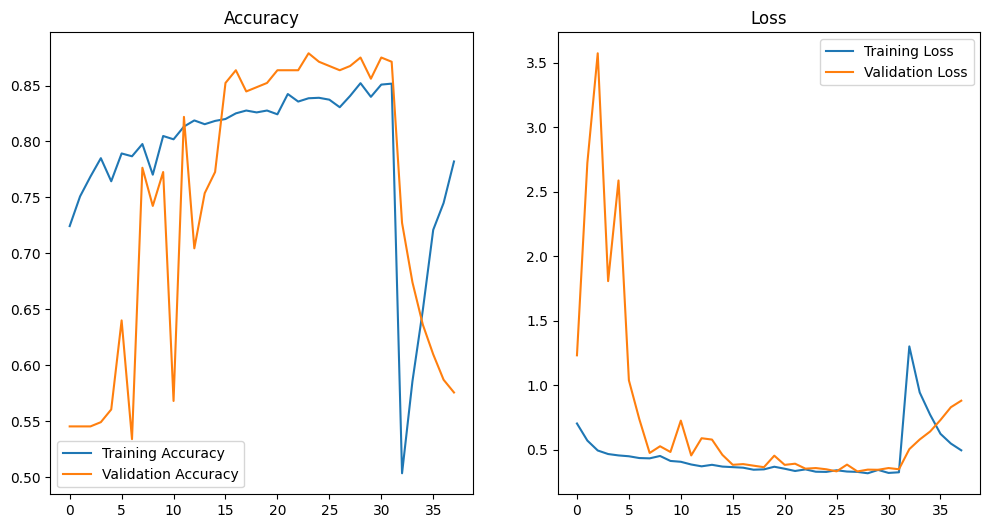

In [14]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_total = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_total, acc, label='Training Accuracy')
plt.plot(epochs_total, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_total, loss, label='Training Loss')
plt.plot(epochs_total, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.8304 - loss: 0.3275
Test Accuracy: 0.8561
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
              precision    recall  f1-score   support

      benign       0.87      0.86      0.87       360
   malignant       0.84      0.85      0.84       300

    accuracy                           0.86       660
   macro avg       0.85      0.86      0.85       660
weighted avg       0.86      0.86      0.86       660



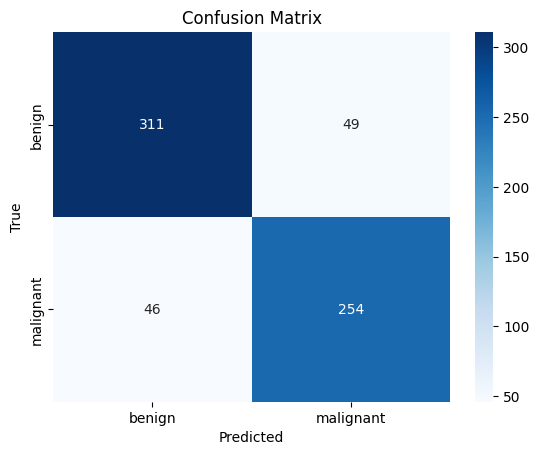

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

predictions = (model.predict(test_generator) > 0.5).astype(int).flatten()
true_labels = test_generator.classes

print(classification_report(true_labels, predictions, target_names=['benign', 'malignant']))

cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


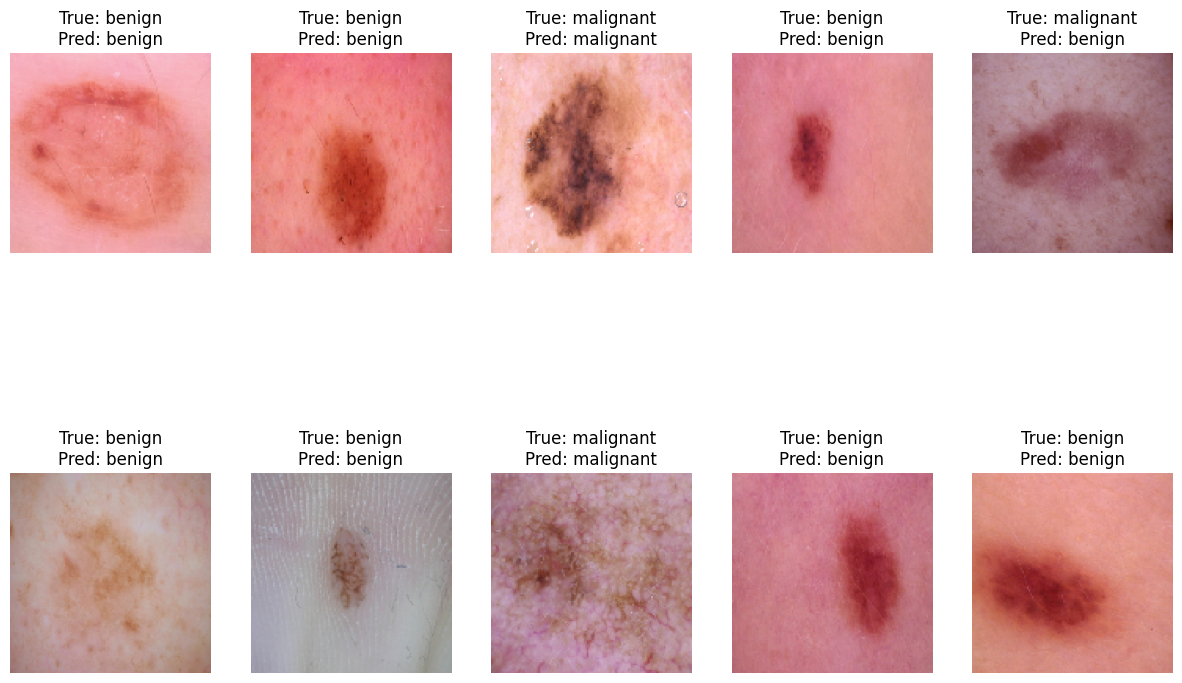

In [10]:
sample_images, sample_labels = next(test_generator)

preds = model.predict(sample_images)
preds = (preds > 0.5).astype(int).flatten()

plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true = 'malignant' if sample_labels[i] == 1 else 'benign'
    pred = 'malignant' if preds[i] == 1 else 'benign'
    plt.title(f'True: {true}\nPred: {pred}')
    plt.axis('off')
plt.show()